In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns #https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
import numpy as np
import pandas as pd
from datetime import datetime, timedelta



import requests


import math
import matplotlib.font_manager as font_manager
import functools
from uuid import uuid4

import logging
from io import StringIO

# M/M/s 

In [2]:
raw_mms_df = pd.read_csv('mms_SimData.csv')
raw_mms_df.head()

,arrival_time,ql,les,numBusy,delay,NI,ql_est,lcs,arr_pct,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg
0,155.491231,1.0,0.000000,6.0,2.595664,46.611008,1.0,0.0,0.323940,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0
1,155.671204,2.0,0.000000,6.0,2.764084,46.611008,2.0,0.0,0.324315,1.5,0.0,0.0,0.0,2.679874,0.00000,0.0,0.0
2,157.154986,3.0,0.000000,6.0,2.198420,46.611008,3.0,0.0,0.327406,2.5,0.0,0.0,0.0,2.481252,0.00000,0.0,0.0
3,157.340310,4.0,0.000000,6.0,2.311244,46.611008,4.0,0.0,0.327792,3.5,0.0,0.0,0.0,2.254832,0.00000,0.0,0.0
4,158.800745,2.0,2.764084,6.0,2.442141,46.611008,2.0,0.0,0.330835,3.0,2.4,0.0,0.0,2.376692,2.46231,0.0,0.0


## Heuristic Evaluation

In [3]:
# Heuristic Evas
#calc mse
from sklearn.metrics import mean_squared_error
h_eval = raw_mms_df.copy()

y_true =  h_eval['delay'].values

print("NI Estimator MSE: %s" % (mean_squared_error(y_true,h_eval['NI'].values)))
print("QL Estimator MSE: %s" % (mean_squared_error(y_true,h_eval['ql_est'].values)))
print("LES Estimator MSE: %s" % (mean_squared_error(y_true,h_eval['les'].values)))
print("lCS Estimator MSE: %s" % (mean_squared_error(y_true,h_eval['lcs'].values)))


NI Estimator MSE: 665.4805289136004
QL Estimator MSE: 24.289661751626497
LES Estimator MSE: 250.27186886304293
lCS Estimator MSE: 267.30609906890135


(46.611008186873526, 46.33165951589331, 46.890356857853746)


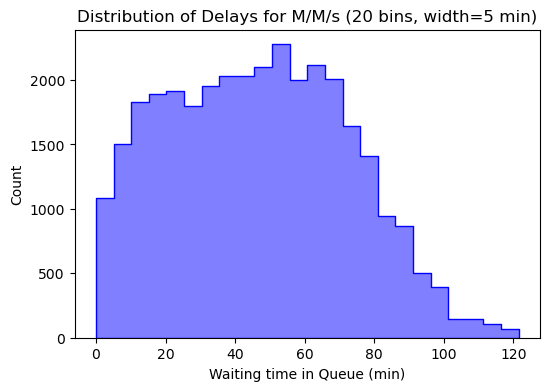

In [164]:
fig, ax = plt.subplots(1, 1,figsize=(6, 4))

sns.histplot(data=raw_mms_df, x = 'delay',element='step',bins=20,binwidth=5,alpha=0.5,color = 'b')

#ax.set_xlim(0, 120)
ax.set_title('Distribution of Delays for M/M/s (20 bins, width=5 min)')
ax.set_ylabel('Count')
ax.set_xlabel('Waiting time in Queue (min)')
print(mean_confidence_interval(raw_mms_df['delay']))

In [165]:
sp.sem(raw_mms_df['delay'])

0.1425221855538866

## ML Evaluation

In [41]:
# To prepare the model
pre_mms = raw_mms_df.copy()

#remove ql = 0 -> no delay conditions
print(len(pre_mms))
pre_mms = pre_mms[pre_mms['ql']>0]
print(len(pre_mms))

#remove ql = 0 -> no delay conditions
print(len(pre_mms))
pre_mms = pre_mms[pre_mms['les']>0]
print(len(pre_mms))


#drop unscaled features:
pre_mms.drop(['arrival_time'],axis=1, inplace=True)
#Ql estimator


pre_mms.to_csv('pre_mms.csv')
pre_mms.head()


32763
32419
32419
32349


,ql,les,numBusy,delay,NI,ql_est,lcs,arr_pct,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg
4,2.0,2.764084,6.0,2.442141,46.611008,2.0,0.000000,0.330835,3.0,2.4,0.0,0.0,2.376692,2.462310,0.0,0.0
5,3.0,2.764084,6.0,3.926405,46.611008,3.0,2.764084,0.330962,2.5,2.8,0.0,0.0,3.184273,2.728459,0.0,0.0
6,2.0,2.311244,6.0,4.025717,46.611008,2.0,2.764084,0.332716,2.5,2.8,0.0,0.0,3.976061,2.980785,0.0,0.0
7,3.0,2.311244,6.0,3.884679,46.611008,3.0,2.311244,0.333121,2.5,2.8,0.0,0.0,3.955198,3.318037,0.0,0.0
8,4.0,2.311244,6.0,3.948249,46.611008,4.0,2.311244,0.333579,3.5,2.8,0.0,0.0,3.916464,3.645438,0.0,0.0


In [42]:
#train test split
from sklearn.model_selection import train_test_split

X = pre_mms.copy()
y = X['delay']
X.drop(columns=['delay'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Feature Engineering

In [43]:
#mutual info
from sklearn.feature_selection import mutual_info_regression
info = dict(zip(X_train.columns, mutual_info_regression(X_train.values, y_train.values)))

info

{'ql': 1.7199894151462365,
 'les': 1.1867944281381524,
 'numBusy': 0.0,
 'NI': 0.0057325351336050545,
 'ql_est': 1.719568250156522,
 'lcs': 1.1596600527961085,
 'arr_pct': 0.8158095091927917,
 'ql_2_avg': 1.6988878579289644,
 'ql_5_avg': 1.644160628494208,
 'ql_10_avg': 1.5356367161640856,
 'ql_20_avg': 1.3814535991095092,
 'dh_2_avg': 3.6925742965989565,
 'dh_5_avg': 2.833552518178771,
 'dh_10_avg': 2.343016041543442,
 'dh_20_avg': 1.8940661348208758}

In [7]:
a = dict(sorted(info.items(), key=lambda item: item[1]))
a

{'numBusy': 0.0,
 'NI': 0.005642780128136238,
 'arr_pct': 0.8158095091927917,
 'lcs': 1.159601269375937,
 'les': 1.1867926798698845,
 'ql_20_avg': 1.3815354677279785,
 'ql_10_avg': 1.5357282189242767,
 'ql_5_avg': 1.6423480490349744,
 'ql_2_avg': 1.6987142943676785,
 'ql_est': 1.7197143991343857,
 'ql': 1.719767542643738,
 'dh_20_avg': 1.894055193867092,
 'dh_10_avg': 2.343016355700918,
 'dh_5_avg': 2.833552518178771,
 'dh_2_avg': 3.6925739558179664}

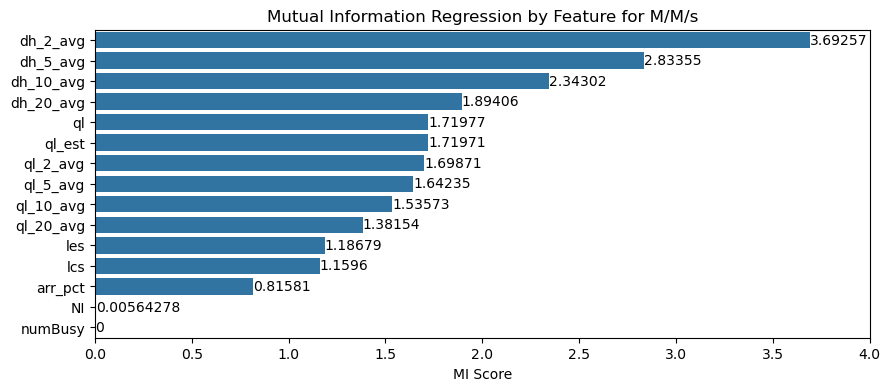

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

sorted_info = dict(sorted(info.items(), key=lambda item: item[1]))
val = list(sorted_info.values())
val.reverse()
index= list(sorted_info.keys())
index.reverse()

sns.barplot(y=index, x=val,orient='h')#,annot=True)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xlim(0, 4)

ax.set_xlabel('MI Score')
ax.set_title('Mutual Information Regression by Feature for M/M/s')
plt.show()

### Decision Tree

In [44]:
from sklearn import tree
dt_reg = tree.DecisionTreeRegressor(random_state=0,max_depth=3,min_samples_leaf=100)
dt_reg.fit(X_train.values, y_train.values)
y_pred_dt = dt_reg.predict(X_test.values)
print
print("DT Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_dt)))

DT Regression Estimator MSE: 17.6781293669857


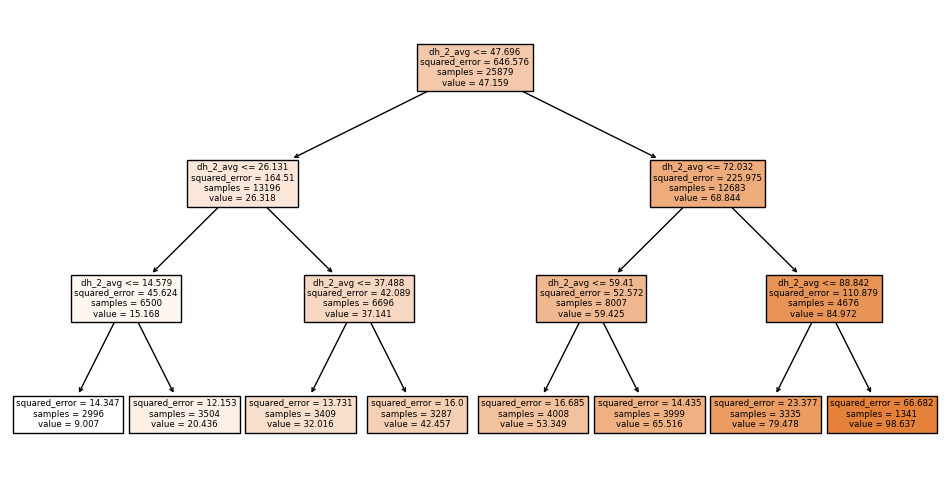

In [45]:
fig = plt.figure(figsize=(12,6))

tree.plot_tree(dt_reg, feature_names=X_train.columns,filled=True)

plt.show()

In [428]:
#Grid Search
from sklearn.model_selection import GridSearchCV

dt_param_grid = {'max_depth':np.arange(2,8,1)}
scoring_ = 'neg_mean_squared_error'

dt_gcv = tree.DecisionTreeRegressor(min_samples_leaf=100)
dt_grid_search = GridSearchCV(dt_gcv,dt_param_grid, cv=5, scoring='neg_mean_squared_error',                 
                                            refit=True,return_train_score=True,n_jobs=2)

dt_grid_search.fit(X_train.values,y_train.values)
                           
print(dt_grid_search.best_params_)

        

{'max_depth': 7}


In [429]:
dt_grid_search.cv_results_['mean_test_score']

array([-59.41390512, -18.55533982,  -6.19786591,  -2.59960868,
        -1.83442682,  -1.67669077])

In [46]:
dt_reg_grid = tree.DecisionTreeRegressor(max_depth=4,min_samples_leaf=100)
dt_reg_grid.fit(X_train.values, y_train.values)
y_pred_dt_gcv = dt_reg_grid.predict(X_test.values)

print("DT (Grid Searc Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_dt_gcv)))

DT (Grid Searc Regression Estimator MSE: 6.1492345760002625


In [47]:
y_test -y_pred_dt_gcv

fig, ax = plt.subplots(1, 1,figsize=(6, 4))

sns.histplot(data=raw_mms_df, x = 'delay',element='step',bins=20,alpha=0.5,color = 'b')

#ax.set_xlim(0, 120)
ax.set_title('Distribution of Delays for M/M/s')
ax.set_ylabel('Count')
ax.set_xlabel('Waiting time in Queue (min)')

16124   -2.224007
20582   -2.985541
19507    2.739747
9211     1.668464
18414   -0.901344
           ...   
28107   -1.194023
10324    2.397447
18548   -1.991477
8846     1.616077
1810    -2.238283
Name: delay, Length: 6470, dtype: float64

In [ ]:
text_visual = tree.export_text(dt_reg_grid,feature_names=list(X.columns),show_weights=True)
print(text_visual)

### Random Forest Regression

In [48]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=3, random_state=0)
rf_reg.fit(X_train.values, y_train.values)
y_pred_rf = rf_reg.predict(X_test.values)

print("RF Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_rf)))

RF Regression Estimator MSE: 15.918275233056635


In [49]:
rf_dict = dict(zip(X.columns, rf_reg.feature_importances_))
print(rf_dict)

{'ql': 0.0, 'les': 0.0, 'numBusy': 0.0, 'NI': 0.0, 'ql_est': 0.0, 'lcs': 0.0, 'arr_pct': 0.0, 'ql_2_avg': 0.0, 'ql_5_avg': 0.0, 'ql_10_avg': 0.0, 'ql_20_avg': 0.0, 'dh_2_avg': 1.0, 'dh_5_avg': 0.0, 'dh_10_avg': 0.0, 'dh_20_avg': 0.0}


In [434]:
#Grid Search
rf_param_grid = {'max_depth':np.arange(2,8,1)}
scoring_ = 'neg_mean_squared_error'
rf_gcv = RandomForestRegressor(min_samples_leaf=100)

rf_grid_search = GridSearchCV(rf_gcv,rf_param_grid, cv=5, scoring='neg_mean_squared_error',
                              refit=True,return_train_score=True,n_jobs=2)

rf_grid_search.fit(X_train.values,y_train.values)

print(rf_grid_search.best_params_)



{'max_depth': 7}


In [435]:
rf_grid_search.cv_results_['mean_test_score']

array([-56.86786869, -16.74821291,  -4.92070816,  -2.47734387,
        -2.0883421 ,  -2.02172957])

In [50]:
rf_reg_grid = RandomForestRegressor(n_estimators=100,
                                    max_depth=4,
                                    min_samples_leaf=100)
rf_reg_grid.fit(X_train.values, y_train.values)
y_pred_rf_gcv = rf_reg_grid.predict(X_test.values)

print("RF (GridSearch) Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_rf_gcv)))

RF (GridSearch) Regression Estimator MSE: 5.203620072393146


### Gradient Boosted Regression

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_reg.fit(X_train.values, y_train.values)
y_pred_gb = gb_reg.predict(X_test.values)

print("GB Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_gb)))

GB Regression Estimator MSE: 0.47667790801057813


In [52]:
gb_dict = dict(zip(X.columns, gb_reg.feature_importances_))
print(gb_dict)

{'ql': 0.00918733009882051, 'les': 0.00027928175700980986, 'numBusy': 0.0, 'NI': 0.0, 'ql_est': 0.014258401499246242, 'lcs': 2.0749347242464814e-05, 'arr_pct': 0.00015344657738424437, 'ql_2_avg': 0.0004366810766716456, 'ql_5_avg': 1.316426264361573e-05, 'ql_10_avg': 1.6223826233803563e-05, 'ql_20_avg': 1.761517072429446e-05, 'dh_2_avg': 0.9751910900563053, 'dh_5_avg': 0.00014010258630133614, 'dh_10_avg': 6.87952943236244e-05, 'dh_20_avg': 0.00021711844709288987}


In [439]:
#Grid Search
gb_param_grid = {'max_depth':np.arange(2,8,1)}

scoring_ = 'neg_mean_squared_error'
gb_gcv = GradientBoostingRegressor(min_samples_leaf=100)

gb_grid_search = GridSearchCV(gb_gcv,dt_param_grid, cv=5, scoring='neg_mean_squared_error',
                              refit=True,return_train_score=True,n_jobs=2)

gb_grid_search.fit(X_train.values,y_train.values)

print(gb_grid_search.best_params_)


{'max_depth': 7}


In [440]:
gb_grid_search.cv_results_['mean_test_score']

array([-1.37355876, -1.07008242, -0.99428579, -0.96871121, -0.97520703,
       -0.95395442])

In [53]:
gb_reg_grid = GradientBoostingRegressor(n_estimators=100,
                                        max_depth=4,
                                        min_samples_leaf=100)
gb_reg_grid.fit(X_train.values, y_train.values)
y_pred_gb_gcv = gb_reg_grid.predict(X_test.values)

print("GB (GridSearch) Regression Estimator MSE: %s" % (mean_squared_error(y_test.values,y_pred_gb_gcv)))

GB (GridSearch) Regression Estimator MSE: 0.636164888044796


## Combined Results

In [513]:
h_eval = raw_mms_df.copy()

y_h_true =  h_eval['delay'].values


mms_results = pd.DataFrame.from_dict({'Type':'M/M/S',
                                      'NI_MSE':[mean_squared_error(y_h_true,h_eval['NI'].values)], 
                                      'QL_MSE':[mean_squared_error(y_h_true,h_eval['ql_est'].values)],
                                      'LES_MSE':[mean_squared_error(y_h_true,h_eval['les'].values)],
                                      'LCS_MSE':[mean_squared_error(y_h_true,h_eval['lcs'].values)],
                                      'DT_MSE':[mean_squared_error(y_test.values,y_pred_dt_gcv)],
                                      'RF_MSE':[mean_squared_error(y_test.values,y_pred_rf_gcv)],
                                      'GB_MSE':[mean_squared_error(y_test.values,y_pred_gb_gcv)]
                                     })

mms_results.head()

,Type,NI_MSE,QL_MSE,LES_MSE,LCS_MSE,DT_MSE,RF_MSE,GB_MSE
0,M/M/S,665.480529,24.289662,250.271869,267.306099,6.149235,5.147683,0.636165


Text(0.5, 0, 'Gradient Boosted Regression')

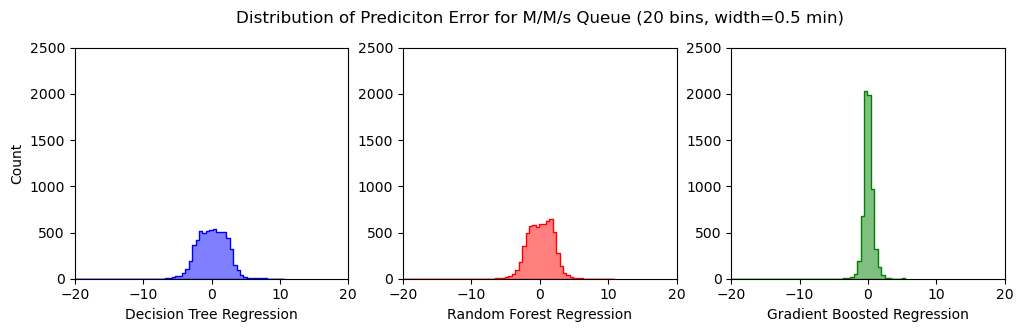

In [161]:
import scipy.stats as sp
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.sem(a)
    h = se * sp.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


fig, ax = plt.subplots(1, 3,figsize=(12, 3))




dt_err =y_test.values -y_pred_dt_gcv
rf_err = y_test.values -y_pred_rf_gcv
gb_err = y_test.values -y_pred_gb_gcv

d = {'dt': dt_err, 'rf': rf_err,'gb':gb_err}
err_hst = pd.DataFrame(data=d)




sns.histplot(data=err_hst,x='dt',element='step',bins=20,binwidth=0.5,alpha=0.5,
             color='b',ax=ax[0])
sns.histplot(data=err_hst, x = 'rf',element='step',bins=20,binwidth=0.5,alpha=0.5,
             color='r',ax=ax[1])
sns.histplot(data=err_hst, x = 'gb',element='step',bins=20,binwidth=0.5,alpha=0.5,
             color='g',ax=ax[2])

ax[0].set_xlim(-20, 20)
ax[1].set_xlim(-20, 20)
ax[2].set_xlim(-20, 20)
ax[0].set_ylim(0, 2500)
ax[1].set_ylim(0, 2500)
ax[2].set_ylim(0, 2500)

ax[1].set_title('Distribution of Prediciton Error for M/M/s Queue (20 bins, width=0.5 min)\n')

ax[0].set_ylabel('Count')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('Decision Tree Regression')
ax[1].set_xlabel('Random Forest Regression')
ax[2].set_xlabel('Gradient Boosted Regression')


In [76]:
import scipy.stats as sp
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.sem(a)
    h = se * sp.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

table_mms_err = pd.DataFrame({'Mean':[],'Upper CI 95%':[],'Lower CI 95%':[]})
j=0
for i in [dt_err,rf_err,gb_err]:
    loop_dict ={}
    CI = mean_confidence_interval(i)
    loop_dict['Mean']=CI[0]
    loop_dict['Upper CI 95%']=CI[1]
    loop_dict['Lower CI 95%']=CI[2]
    df = pd.DataFrame(loop_dict,index=[j])
    j=j+1
    table_mms_err = pd.concat([table_mms_err,df])
table_mms_err

,Mean,Upper CI 95%,Lower CI 95%
0,0.051658,-0.008769,0.112084
1,0.055525,-0.000057,0.111108
2,0.005636,-0.013803,0.025076


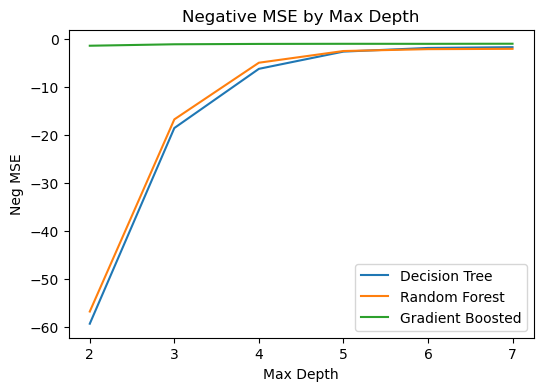

In [469]:
#depth chart

fig, ax = plt.subplots(figsize=(6,4))
dep = [2,3,4,5,6,7]

dt_dep = list(dt_grid_search.cv_results_['mean_test_score'])
rf_dep = list(rf_grid_search.cv_results_['mean_test_score'])
gb_dep = list(gb_grid_search.cv_results_['mean_test_score'])

ax.plot(dep,dt_dep)
ax.plot(dep,rf_dep)
ax.plot(dep,gb_dep)
#ax.vlines(x=5, ymin=-100, ymax=10, linewidth=0.5, color='r')
ax.legend(['Decision Tree','Random Forest','Gradient Boosted'])

ax.set_title('Negative MSE by Max Depth')
ax.set_ylabel('Neg MSE')
ax.set_xlabel('Max Depth')
#ax.set_ylim(-60, 0)
#ax.set_xlim(2, 7)

plt.show()

# N-State

In [80]:
raw_nst_df = pd.read_csv('NState_SimData.csv')
raw_nst_df.head()

,arrival_time,ql,les,numBusy,delay,queue_type,ql_est,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg,arr_pct,lcs,NI
0,339.253643,33.0,47.729287,3.0,106.361378,2.0,66.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.706778,0.000000,35.863852
1,341.373823,34.0,47.729287,3.0,105.483878,2.0,68.0,33.5,0.0,0.0,0.0,105.922628,0.000000,0.0,0.0,0.711195,47.729287,35.863852
2,343.316047,35.0,47.729287,3.0,105.296837,2.0,70.0,34.5,0.0,0.0,0.0,105.390358,0.000000,0.0,0.0,0.715242,47.729287,35.863852
3,346.896349,36.0,47.729287,3.0,102.476567,2.0,72.0,35.5,0.0,0.0,0.0,103.886702,0.000000,0.0,0.0,0.722701,47.729287,35.863852
4,349.206231,37.0,47.729287,3.0,103.065361,2.0,74.0,36.5,35.0,0.0,0.0,102.770964,104.536804,0.0,0.0,0.727513,47.729287,35.863852


## Heuristic Evaluation

In [81]:
# Q1
q1 = raw_nst_df[raw_nst_df['queue_type']==1].copy()


y_true =  q1['delay'].values

print("NI Estimator MSE: %s" % (mean_squared_error(y_true,q1['NI'].values)))
print("QL Estimator MSE: %s" % (mean_squared_error(y_true,q1['ql_est'].values)))
print("LES Estimator MSE: %s" % (mean_squared_error(y_true,q1['les'].values)))
print("lCS Estimator MSE: %s" % (mean_squared_error(y_true,q1['lcs'].values)))

NI Estimator MSE: 1217.837759287236
QL Estimator MSE: 3289.959878273086
LES Estimator MSE: 1921.2228196761296
lCS Estimator MSE: 1926.186999059914


In [82]:
#Q2
q2 = raw_nst_df[raw_nst_df['queue_type']==2].copy()


y_true =  q2['delay'].values

print("NI Estimator MSE: %s" % (mean_squared_error(y_true,q2['NI'].values)))
print("QL Estimator MSE: %s" % (mean_squared_error(y_true,q2['ql_est'].values)))
print("LES Estimator MSE: %s" % (mean_squared_error(y_true,q2['les'].values)))
print("lCS Estimator MSE: %s" % (mean_squared_error(y_true,q2['lcs'].values)))

NI Estimator MSE: 3446.683543634759
QL Estimator MSE: 3643.7691460292926
LES Estimator MSE: 4333.03055459693
lCS Estimator MSE: 4380.9824649477805


In [83]:
#Overall
overall = raw_nst_df.copy()


y_true =  overall['delay'].values

print("NI Estimator MSE: %s" % (mean_squared_error(y_true,overall['NI'].values)))
print("QL Estimator MSE: %s" % (mean_squared_error(y_true,overall['ql_est'].values)))
print("LES Estimator MSE: %s" % (mean_squared_error(y_true,overall['les'].values)))
print("lCS Estimator MSE: %s" % (mean_squared_error(y_true,overall['lcs'].values)))

NI Estimator MSE: 1918.5139430066645
QL Estimator MSE: 3401.185934932971
LES Estimator MSE: 2679.4162538907854
lCS Estimator MSE: 2697.894369273322


Text(0.5, 0, 'Waiting time in Queue (min)')

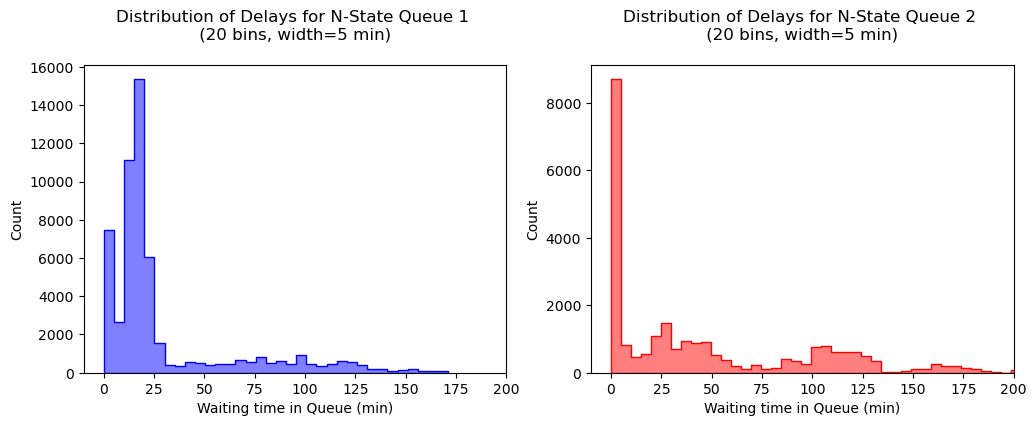

In [162]:
fig, ax = plt.subplots(1, 2,figsize=(12, 4))

sns.histplot(data=raw_nst_df[raw_nst_df['queue_type']==1], x = 'delay',element='step',bins=20,binwidth=5,alpha=0.5,
             color='b',ax=ax[0])
sns.histplot(data=raw_nst_df[raw_nst_df['queue_type']==2], x = 'delay',element='step',bins=20,binwidth=5,alpha=0.5,
             color='r',ax=ax[1])


ax[0].set_title('Distribution of Delays for N-State Queue 1 \n (20 bins, width=5 min) \n')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Waiting time in Queue (min)')
ax[0].set_xlim(-10, 200)
ax[1].set_title('Distribution of Delays for N-State Queue 2 \n (20 bins, width=5 min) \n')
ax[1].set_ylabel('Count')
ax[1].set_xlim(-10, 200)
ax[1].set_xlabel('Waiting time in Queue (min)')

In [168]:
print(mean_confidence_interval(raw_nst_df[raw_nst_df['queue_type']==1]['delay']))
print(mean_confidence_interval(raw_nst_df[raw_nst_df['queue_type']==2]['delay']))

(29.378611859269576, 29.093891321071624, 29.663332397467528)
(50.00811248053908, 49.30937398088274, 50.706850980195426)


## Machine Learning Evalulation

In [85]:
# To prepare the model
pre_nst = raw_nst_df.copy()

#remove ql = 0 -> no delay conditions
print(len(pre_nst))
pre_nst = pre_nst[pre_nst['ql']>0]
print(len(pre_nst))

#remove ql = 0 -> no delay conditions
print(len(pre_nst))
pre_nst = pre_nst[pre_nst['les']>0]
print(len(pre_nst))

#Ql estimator


pre_nst.to_csv('pre_nst.csv')
pre_nst.head()


81268
68247
68247
66767


,arrival_time,ql,les,numBusy,delay,queue_type,ql_est,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg,arr_pct,lcs,NI
0,339.253643,33.0,47.729287,3.0,106.361378,2.0,66.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.706778,0.000000,35.863852
1,341.373823,34.0,47.729287,3.0,105.483878,2.0,68.0,33.5,0.0,0.0,0.0,105.922628,0.000000,0.0,0.0,0.711195,47.729287,35.863852
2,343.316047,35.0,47.729287,3.0,105.296837,2.0,70.0,34.5,0.0,0.0,0.0,105.390358,0.000000,0.0,0.0,0.715242,47.729287,35.863852
3,346.896349,36.0,47.729287,3.0,102.476567,2.0,72.0,35.5,0.0,0.0,0.0,103.886702,0.000000,0.0,0.0,0.722701,47.729287,35.863852
4,349.206231,37.0,47.729287,3.0,103.065361,2.0,74.0,36.5,35.0,0.0,0.0,102.770964,104.536804,0.0,0.0,0.727513,47.729287,35.863852


In [86]:
q1_df = pre_nst[pre_nst['queue_type']==1].copy()
q2_df = pre_nst[pre_nst['queue_type']==2].copy()
overall_df = pre_nst.copy()

### Mutual Information By Queue

#### Q1

In [119]:
X1 = q1_df.copy()
y1 = X1['delay']
X1.drop(columns=['delay','queue_type'], inplace=True)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [120]:
info1 = dict(zip(X_train1.columns, mutual_info_regression(X_train1.values, y_train1.values)))
info1

{'arrival_time': 7.48485332797036,
 'ql': 3.393480363781646,
 'les': 6.492353595762055,
 'numBusy': 5.946525166455885e-05,
 'ql_est': 3.3934334473832806,
 'ql_2_avg': 3.9376643006097645,
 'ql_5_avg': 4.7847055764634,
 'ql_10_avg': 5.320531532185709,
 'ql_20_avg': 5.813084504931596,
 'dh_2_avg': 7.594387947365953,
 'dh_5_avg': 7.537668362373855,
 'dh_10_avg': 7.510906787261771,
 'dh_20_avg': 7.497846299698438,
 'arr_pct': 7.4836060525985175,
 'lcs': 6.481623579343365,
 'NI': 0.011087254334567476}

#### Q2

In [121]:
X2 = q2_df.copy()
y2 = X2['delay']
X2.drop(columns=['delay','queue_type'], inplace=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [122]:
info2 = dict(zip(X_train2.columns, mutual_info_regression(X_train2.values, y_train2.values)))
info2

{'arrival_time': 5.578504590413091,
 'ql': 3.076901227145258,
 'les': 4.43168808257872,
 'numBusy': 0.0014915739945084994,
 'ql_est': 3.0793695883327716,
 'ql_2_avg': 3.4886151098700755,
 'ql_5_avg': 4.110642638039916,
 'ql_10_avg': 4.571727947373265,
 'ql_20_avg': 4.904547863933599,
 'dh_2_avg': 5.729095176731837,
 'dh_5_avg': 5.641814547169931,
 'dh_10_avg': 5.596825696153093,
 'dh_20_avg': 5.523770306784126,
 'arr_pct': 5.57888576555429,
 'lcs': 4.405664390921512,
 'NI': 0.0034694615106634075}

#### Overall

In [123]:
X_n = q2_df.copy()
y_n = X_n['delay']
X_n.drop(columns=['delay','queue_type'], inplace=True)

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

In [124]:
infoN = dict(zip(X_train_n.columns, mutual_info_regression(X_train_n.values, y_train_n.values)))
infoN

{'arrival_time': 5.573592973977042,
 'ql': 3.072030007428324,
 'les': 4.422684548089613,
 'numBusy': 0.0,
 'ql_est': 3.077919440705427,
 'ql_2_avg': 3.4880847981210046,
 'ql_5_avg': 4.114248650744489,
 'ql_10_avg': 4.577630930330653,
 'ql_20_avg': 4.9050336961781404,
 'dh_2_avg': 5.722038226469094,
 'dh_5_avg': 5.642520051371772,
 'dh_10_avg': 5.588622133289622,
 'dh_20_avg': 5.51975299064434,
 'arr_pct': 5.583210696504599,
 'lcs': 4.406544811335181,
 'NI': 0.004047705095773679}

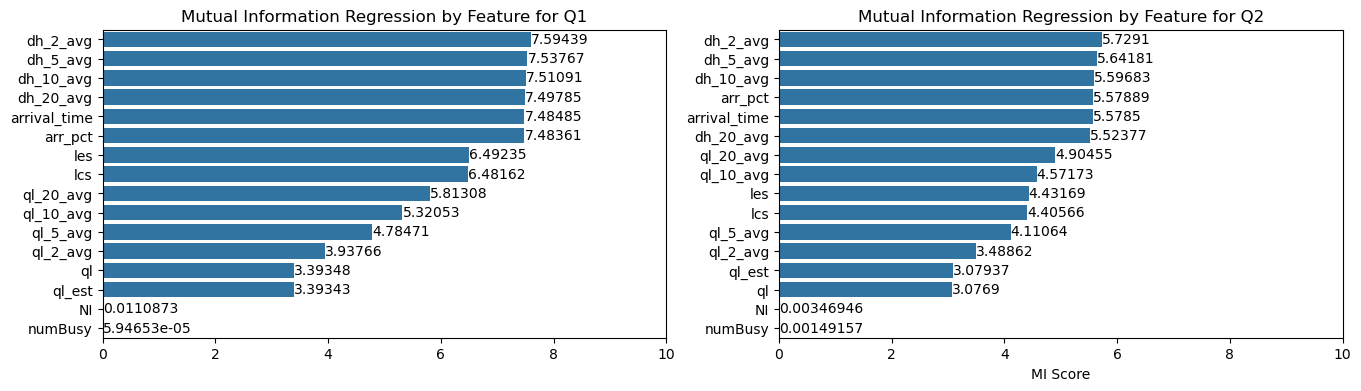

In [126]:
fig, ax = plt.subplots(1,2,figsize=(16,4))

sort_q1 = dict(sorted(info1.items(), key=lambda item: item[1]))
val_q1 = list(sort_q1.values())
val_q1.reverse()
index_q1= list(sort_q1.keys())
index_q1.reverse()

sort_q2 = dict(sorted(info2.items(), key=lambda item: item[1]))
val_q2 = list(sort_q2.values())
val_q2.reverse()
index_q2= list(sort_q2.keys())
index_q2.reverse()

sort_n = dict(sorted(infoN.items(), key=lambda item: item[1]))
val_n = list(sort_n.values())
val_n.reverse()
index_n= list(sort_n.keys())
index_n.reverse()

sns.barplot(y=index_q1, x=val_q1,orient='h',ax=ax[0])#,annot=True)
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].set_xlim(0, 10)

sns.barplot(y=index_q2, x=val_q2,orient='h',ax=ax[1])#,annot=True)
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].set_xlim(0, 10)
'''
sns.barplot(y=index_n, x=val_n,orient='h',ax=ax[2])#,annot=True)
ax[2].bar_label(ax[2].containers[0], fontsize=10)
ax[2].set_xlim(0, 10)
'''
ax[1].set_xlabel('MI Score')
ax[0].set_title('Mutual Information Regression by Feature for Q1')
ax[1].set_title('Mutual Information Regression by Feature for Q2')
plt.show()

### Model Grid


In [87]:
def split_fit_score(df,target):
    
    #Split
    X = df.copy()
    y = X[target]
    X.drop(columns=['delay','queue_type'], inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Decision Tree Regression
    dt_reg = tree.DecisionTreeRegressor(random_state=0,
                                        max_depth=4,
                                        min_samples_leaf=100)
    dt_reg.fit(X_train.values, y_train.values)
    y_pred_dt = dt_reg.predict(X_test.values)
    dt_mse = mean_squared_error(y_test.values,y_pred_dt)
    print("DT Regression Estimator MSE: %s" % (dt_mse))
    
    #Random Forest Regression
    rf_reg = RandomForestRegressor(random_state=0,
                                   max_depth=4,
                                   n_estimators=100,
                                   min_samples_leaf=100)
    rf_reg.fit(X_train.values, y_train.values)
    y_pred_rf = rf_reg.predict(X_test.values)
    rf_mse = mean_squared_error(y_test.values,y_pred_rf)
    print("RF Regression Estimator MSE: %s" % (rf_mse))
    
    #Gradient Boosted Regression
    gb_reg = GradientBoostingRegressor(random_state=0,
                                       max_depth=4,
                                       n_estimators=100,
                                       min_samples_leaf=100)
    gb_reg.fit(X_train.values, y_train.values)
    y_pred_gb = gb_reg.predict(X_test.values)
    gb_mse = mean_squared_error(y_test.values,y_pred_gb)
    print("GB Regression Estimator MSE: %s" % (gb_mse))
    
    output = {}
    output['dt_reg'] = {'mdl':dt_reg,'features':X.columns,'mse':dt_mse,'y_true':y_test.values,'y_pred':dt_reg.predict(X_test.values)}
    output['rf_reg'] = {'mdl':rf_reg,'features':dict(zip(X.columns, rf_reg.feature_importances_)),'mse':rf_mse,'y_true':y_test.values,'y_pred':rf_reg.predict(X_test.values)}
    output['gb_reg'] = {'mdl':gb_reg,'features':dict(zip(X.columns, gb_reg.feature_importances_)),'mse':gb_mse,'y_true':y_test.values,'y_pred':gb_reg.predict(X_test.values)}
    
    return output

In [111]:
df_list = [q1_df,q2_df,overall_df]
name_list = ['q1','q2','overall']

loop_dict = {}
for i,j in enumerate(df_list):
    print(name_list[i])
    loop_dict[name_list[i]] = split_fit_score(j,'delay')
for i in name_list:
    for j in ['dt_reg','rf_reg','gb_reg']:
        loop_dict[i][j]['features']

q1
DT Regression Estimator MSE: 13.946480271375188
RF Regression Estimator MSE: 12.756843490628357
GB Regression Estimator MSE: 1.1807535472701882
q2
DT Regression Estimator MSE: 45.17342307641653
RF Regression Estimator MSE: 41.15968590115179
GB Regression Estimator MSE: 11.240113735896108
overall
DT Regression Estimator MSE: 22.795801394042996
RF Regression Estimator MSE: 20.64287711711101
GB Regression Estimator MSE: 3.289482984316497


## Combined Results

In [89]:
#Q1

h_eval = q1_df.copy()

y_h_true =  h_eval['delay'].values

Nst_results_q1 = pd.DataFrame.from_dict({'Type':'N-State Q1',
                                      'NI_MSE':[mean_squared_error(y_h_true,h_eval['NI'].values)], 
                                      'QL_MSE':[mean_squared_error(y_h_true,h_eval['ql_est'].values)],
                                      'LES_MSE':[mean_squared_error(y_h_true,h_eval['les'].values)],
                                      'LCS_MSE':[mean_squared_error(y_h_true,h_eval['lcs'].values)],
                                      'DT_MSE':[mean_squared_error(loop_dict['q1']['dt_reg']['y_true'],
                                                                   loop_dict['q1']['dt_reg']['y_pred'])],
                                      'RF_MSE':[mean_squared_error(loop_dict['q1']['rf_reg']['y_true'],
                                                                   loop_dict['q1']['rf_reg']['y_pred'])],
                                      'GB_MSE':[mean_squared_error(loop_dict['q1']['gb_reg']['y_true'],
                                                                   loop_dict['q1']['gb_reg']['y_pred'])]
                                     })

Nst_results_q1.head()

,Type,NI_MSE,QL_MSE,LES_MSE,LCS_MSE,DT_MSE,RF_MSE,GB_MSE
0,N-State Q1,1253.205491,3523.517208,1963.443903,1951.522887,13.94648,12.756843,1.180754


In [90]:
#Q1

h_eval = q2_df.copy()

y_h_true =  h_eval['delay'].values

Nst_results_q2 = pd.DataFrame.from_dict({'Type':'N-State Q2',
                                      'NI_MSE':[mean_squared_error(y_h_true,h_eval['NI'].values)], 
                                      'QL_MSE':[mean_squared_error(y_h_true,h_eval['ql_est'].values)],
                                      'LES_MSE':[mean_squared_error(y_h_true,h_eval['les'].values)],
                                      'LCS_MSE':[mean_squared_error(y_h_true,h_eval['lcs'].values)],
                                      'DT_MSE':[mean_squared_error(loop_dict['q2']['dt_reg']['y_true'],
                                                                   loop_dict['q2']['dt_reg']['y_pred'])],
                                      'RF_MSE':[mean_squared_error(loop_dict['q2']['rf_reg']['y_true'],
                                                                   loop_dict['q2']['rf_reg']['y_pred'])],
                                      'GB_MSE':[mean_squared_error(loop_dict['q2']['gb_reg']['y_true'],
                                                                   loop_dict['q2']['gb_reg']['y_pred'])]
                                     })

Nst_results_q2.head()

,Type,NI_MSE,QL_MSE,LES_MSE,LCS_MSE,DT_MSE,RF_MSE,GB_MSE
0,N-State Q2,3593.82612,3265.843695,4189.856645,4238.605784,45.173423,41.159686,11.240114


In [91]:
h_eval = overall_df.copy()

y_h_true =  h_eval['delay'].values

Nst_results_overall = pd.DataFrame.from_dict({'Type':'N-State Overall',
                                      'NI_MSE':[mean_squared_error(y_h_true,h_eval['NI'].values)], 
                                      'QL_MSE':[mean_squared_error(y_h_true,h_eval['ql_est'].values)],
                                      'LES_MSE':[mean_squared_error(y_h_true,h_eval['les'].values)],
                                      'LCS_MSE':[mean_squared_error(y_h_true,h_eval['lcs'].values)],
                                      'DT_MSE':[mean_squared_error(loop_dict['overall']['dt_reg']['y_true'],
                                                                   loop_dict['overall']['dt_reg']['y_pred'])],
                                      'RF_MSE':[mean_squared_error(loop_dict['overall']['rf_reg']['y_true'],
                                                                   loop_dict['overall']['rf_reg']['y_pred'])],
                                      'GB_MSE':[mean_squared_error(loop_dict['overall']['gb_reg']['y_true'],
                                                                   loop_dict['overall']['gb_reg']['y_pred'])]
                                     })

Nst_results_overall.head()

,Type,NI_MSE,QL_MSE,LES_MSE,LCS_MSE,DT_MSE,RF_MSE,GB_MSE
0,N-State Overall,1859.473455,3456.77457,2540.12972,2543.923498,22.795801,20.642877,3.289483


Text(0.5, 0, 'Gradient Boosted Regression')

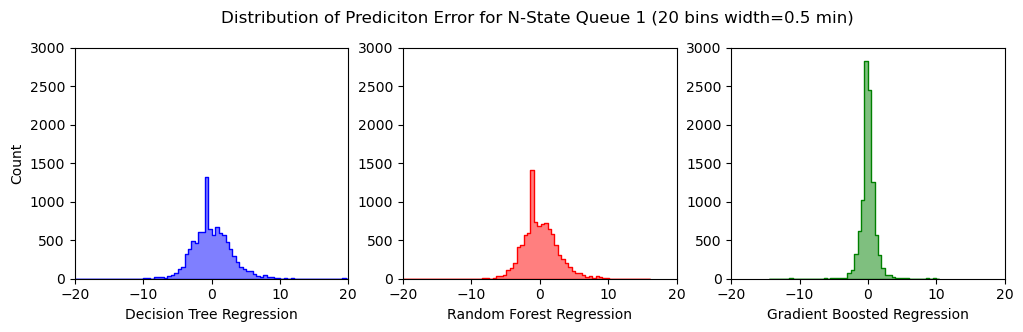

In [146]:
fig, ax = plt.subplots(1, 3,figsize=(12, 3))

#Q1


q1_dt_err =loop_dict['q1']['dt_reg']['y_true'] -loop_dict['q1']['dt_reg']['y_pred']
q1_rf_err = loop_dict['q1']['rf_reg']['y_true'] -loop_dict['q1']['rf_reg']['y_pred']
q1_gb_err = loop_dict['q1']['gb_reg']['y_true'] -loop_dict['q1']['gb_reg']['y_pred']

d = {'dt': q1_dt_err, 'rf': q1_rf_err,'gb':q1_gb_err}
err_hst = pd.DataFrame(data=d)




sns.histplot(data=err_hst,x='dt',element='step',bins=20,alpha=0.5,
             color='b',ax=ax[0],binwidth=0.5)
sns.histplot(data=err_hst, x = 'rf',element='step',bins=20,alpha=0.5,
             color='r',ax=ax[1],binwidth=0.5)
sns.histplot(data=err_hst, x = 'gb',element='step',bins=20,alpha=0.5,
             color='g',ax=ax[2],binwidth=0.5)

ax[0].set_xlim(-20, 20)
ax[1].set_xlim(-20, 20)
ax[2].set_xlim(-20, 20)
ax[0].set_ylim(0, 3000)
ax[1].set_ylim(0, 3000)
ax[2].set_ylim(0, 3000)


ax[1].set_title('Distribution of Prediciton Error for N-State Queue 1 (20 bins width=0.5 min) \n')

ax[0].set_ylabel('Count')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('Decision Tree Regression')
ax[1].set_xlabel('Random Forest Regression')
ax[2].set_xlabel('Gradient Boosted Regression')

In [109]:
table_err = pd.DataFrame({'Mean':[],'Upper CI 95%':[],'Lower CI 95%':[]})
j=0
loop_err ={}
for i in [q1_dt_err,q1_rf_err,q1_gb_err]:
    loop_dict ={}
    CI = mean_confidence_interval(i)
    loop_err['Mean']=CI[0]
    loop_err['Upper CI 95%']=CI[1]
    loop_err['Lower CI 95%']=CI[2]
    df = pd.DataFrame(loop_dict,index=[j])
    j=j+1
    table_err = pd.concat([table_err,df])
table_err

,Mean,Upper CI 95%,Lower CI 95%
0,-0.037882,-0.111473,0.035709
1,-0.028540,-0.098924,0.041844
2,-0.000194,-0.021608,0.021220


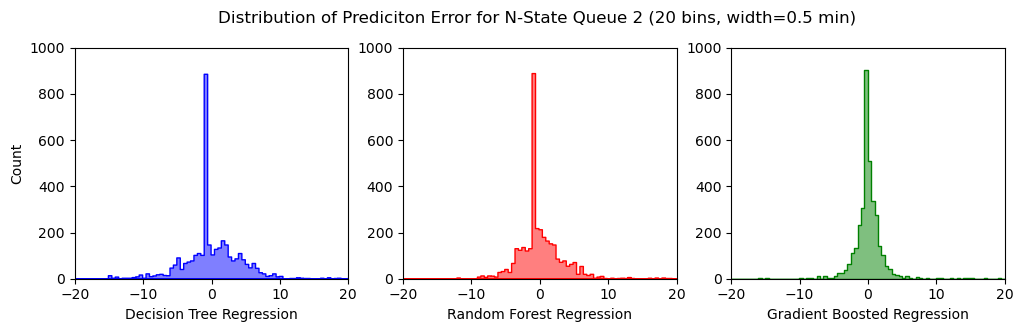

In [145]:
fig, ax = plt.subplots(1, 3,figsize=(12, 3))

#Q1


q2_dt_err =loop_dict['q2']['dt_reg']['y_true'] -loop_dict['q2']['dt_reg']['y_pred']
q2_rf_err = loop_dict['q2']['rf_reg']['y_true'] -loop_dict['q2']['rf_reg']['y_pred']
q2_gb_err = loop_dict['q2']['gb_reg']['y_true'] -loop_dict['q2']['gb_reg']['y_pred']

d = {'dt': q2_dt_err, 'rf': q2_rf_err,'gb':q2_gb_err}
err_hst = pd.DataFrame(data=d)




sns.histplot(data=err_hst,x='dt',element='step',bins=20,alpha=0.5,binwidth=0.5,
             color='b',ax=ax[0])
sns.histplot(data=err_hst, x = 'rf',element='step',bins=20,alpha=0.5,binwidth=0.5,
             color='r',ax=ax[1])
sns.histplot(data=err_hst, x = 'gb',element='step',bins=20,alpha=0.5,binwidth=0.5,
             color='g',ax=ax[2])

ax[0].set_xlim(-20, 20)
ax[1].set_xlim(-20, 20)
ax[2].set_xlim(-20, 20)
ax[0].set_ylim(0, 1000)
ax[1].set_ylim(0, 1000)
ax[2].set_ylim(0, 1000)


ax[1].set_title('Distribution of Prediciton Error for N-State Queue 2 (20 bins, width=0.5 min) \n')

ax[0].set_ylabel('Count')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('Decision Tree Regression')
ax[1].set_xlabel('Random Forest Regression')
ax[2].set_xlabel('Gradient Boosted Regression')
plt.show()

In [116]:
table_err = pd.DataFrame({'Mean':[],'Upper CI 95%':[],'Lower CI 95%':[]})
j=0
loop_err ={}
for i in [q2_dt_err,q2_rf_err,q2_gb_err]:
    loop_err ={}
    CI = mean_confidence_interval(i)
    loop_err['Mean']=CI[0]
    loop_err['Upper CI 95%']=CI[1]
    loop_err['Lower CI 95%']=CI[2]
    df = pd.DataFrame(loop_err,index=[j])
    j=j+1
    table_err = pd.concat([table_err,df])
table_err

,Mean,Upper CI 95%,Lower CI 95%
0,0.027908,-0.196183,0.252000
1,0.082410,-0.131478,0.296299
2,0.063194,-0.048568,0.174956


In [163]:
o_dt_err =loop_dict['overall']['dt_reg']['y_true'] -loop_dict['overall']['dt_reg']['y_pred']
o_rf_err = loop_dict['overall']['rf_reg']['y_true'] -loop_dict['overall']['rf_reg']['y_pred']
o_gb_err = loop_dict['overall']['gb_reg']['y_true'] -loop_dict['overall']['gb_reg']['y_pred']


table_err = pd.DataFrame({'Mean':[],'Upper CI 95%':[],'Lower CI 95%':[]})
j=0
loop_err ={}
for i in [o_dt_err,o_rf_err,o_gb_err]:
    loop_err ={}
    CI = mean_confidence_interval(i)
    loop_err['Mean']=CI[0]
    loop_err['Upper CI 95%']=CI[1]
    loop_err['Lower CI 95%']=CI[2]
    df = pd.DataFrame(loop_err,index=[j])
    j=j+1
    table_err = pd.concat([table_err,df])
table_err

,Mean,Upper CI 95%,Lower CI 95%
0,-0.012021,-0.093010,0.068967
1,-0.006043,-0.083112,0.071027
2,0.023397,-0.007366,0.054159


# Prepare Results

In [606]:
data = pd.concat([mms_results,Nst_results_q1,Nst_results_q2,Nst_results_overall])
data

,Type,NI_MSE,QL_MSE,LES_MSE,LCS_MSE,DT_MSE,RF_MSE,GB_MSE
0,M/M/S,665.480529,24.289662,250.271869,267.306099,6.149235,5.147683,0.636165
0,N-State Q1,1253.205491,3523.517208,1963.443903,1951.522887,13.946480,12.756843,1.180754
0,N-State Q2,3593.826120,3265.843695,4189.856645,4238.605784,45.173423,41.159686,11.240114
0,N-State Overall,1859.473455,3456.774570,2540.129720,2543.923498,22.795801,20.642877,3.289483


In [533]:
#how do I normalize MSE results?
data.to_csv('final_results.csv')

In [490]:
path_mms_df = pd.read_csv('mms_SimData_samplePath.csv')
path_mms_df.head()

,arrival_time,ql,les,numBusy,delay,NI,ql_est,lcs,arr_pct,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg
0,2.198300,0.0,0.0,0.0,0.0,38.989641,0.0,0.0,0.004580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.844900,0.0,0.0,1.0,0.0,38.989641,0.0,0.0,0.008010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.904848,0.0,0.0,2.0,0.0,38.989641,0.0,0.0,0.008135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.652426,0.0,0.0,3.0,0.0,38.989641,0.0,0.0,0.009693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.403910,0.0,0.0,3.0,0.0,38.989641,0.0,0.0,0.017508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


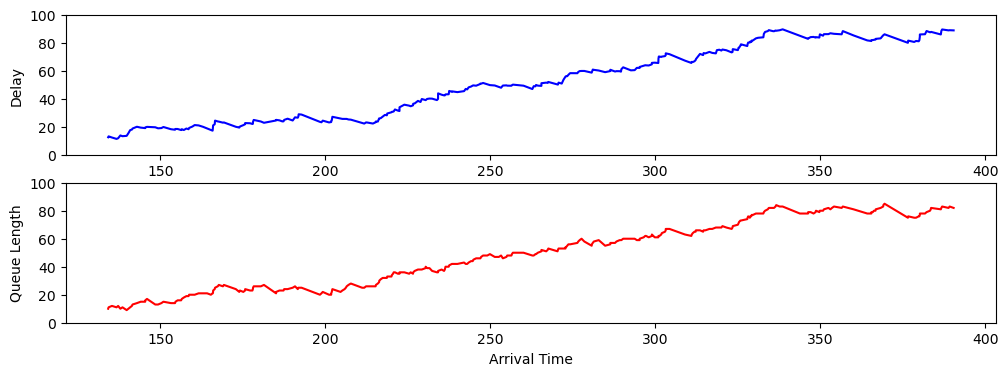

In [504]:
fig, ax = plt.subplots(2,1,figsize=(12,4))

path_mms_df = pd.read_csv('mms_SimData_samplePath.csv')

x = path_mms_df['arrival_time'].values
y1= path_mms_df['delay'].values
y2= path_mms_df['ql'].values

ax[0].plot(x[100:],y1[100:],color='b')
ax[1].plot(x[100:],y2[100:],color='r')


#ax[0].set_title('Delay by Arrival Time')
ax[0].set_ylabel('Delay')
ax[0].set_xlabel('Arrival Time')
ax[0].set_ylim(0, 100)


#ax[1].set_title('Queue Length by Arrival Time')
ax[1].set_ylabel('Queue Length')
ax[1].set_xlabel('Arrival Time')
ax[1].set_ylim(0, 100)

plt.show()

In [565]:
path_ns_df = pd.read_csv('Nstate_SimData_samplePath.csv')
path_ns_df.head()

,arrival_time,ql,les,numBusy,delay,queue_type,ql_est,ql_2_avg,ql_5_avg,ql_10_avg,ql_20_avg,dh_2_avg,dh_5_avg,dh_10_avg,dh_20_avg,arr_pct,lcs,NI
0,13.806791,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028764,0.0,25.516055
1,17.119716,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035666,0.0,25.516055
2,18.417208,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038369,0.0,25.516055
3,23.654574,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049280,0.0,25.516055
4,30.964803,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064510,0.0,25.516055


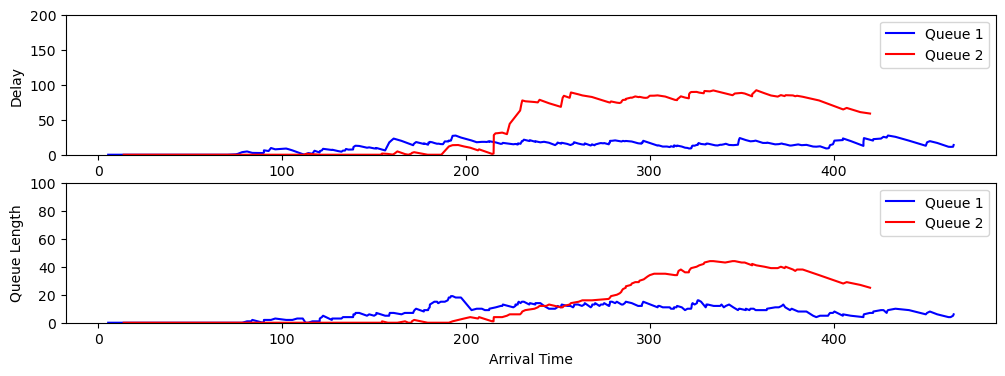

In [586]:
fig, ax = plt.subplots(2,1,figsize=(12,4))

q1_path = path_ns_df[path_ns_df['queue_type']==1].copy()
q2_path = path_ns_df[path_ns_df['queue_type']==2].copy()

x_q1 = q1_path['arrival_time'].values
x_q2 = q2_path['arrival_time'].values
y1_q1= q1_path['delay'].values
y2_q1= q1_path['ql'].values
y1_q2= q2_path['delay'].values
y2_q2= q2_path['ql'].values

ax[0].plot(x_q1,y1_q1,color='b')
ax[0].plot(x_q2,y1_q2,color='r')
ax[1].plot(x_q1,y2_q1,color='b')
ax[1].plot(x_q2,y2_q2,color='r')



#ax[0].set_title('Delay by Arrival Time')
ax[0].set_ylabel('Delay')
ax[0].set_xlabel('Arrival Time')
ax[0].set_ylim(0, 200)
ax[0].legend(['Queue 1','Queue 2'])

#ax[1].set_title('Queue Length by Arrival Time')
ax[1].set_ylabel('Queue Length')
ax[1].set_xlabel('Arrival Time')
ax[1].set_ylim(0, 100)
ax[1].legend(['Queue 1','Queue 2'])

plt.show()